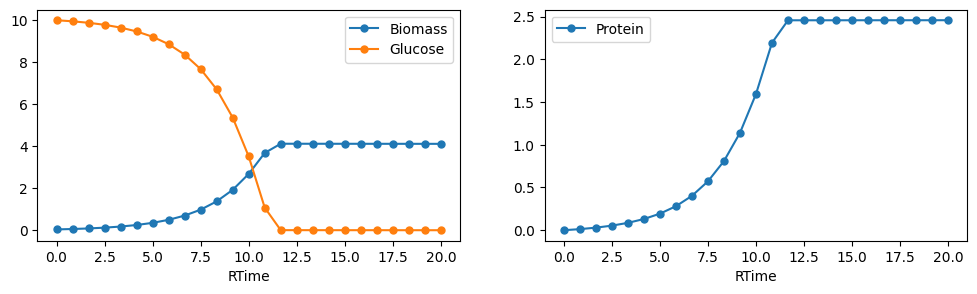

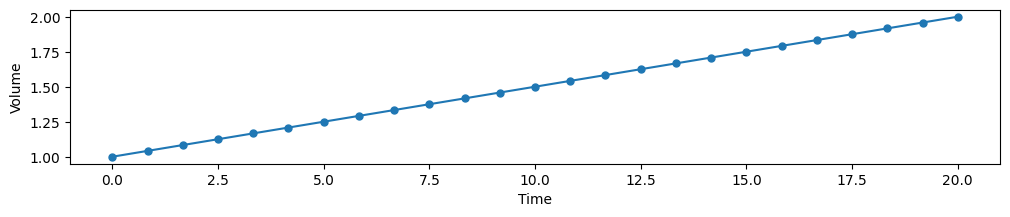

In [97]:
from typing import Union
from matplotlib import markers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import copy
import torch
import torch.nn as nn

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

pd.options.mode.chained_assignment = None
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

T_START = 0
T_END = 20
NUM_SAMPLES = 25

# parameter values
mumax = 0.45      # 1/hour
Ks = 0.20         # g/liter
Yxs = 0.41         # g/g
Ypx = 0.12        # g/g
Sin = 10.0         # g/liter

# inlet flowrate
F0 = 0.05
def Fs(t):
    return F0

V0 = 1.0
def Volume(t):
    return V0 + F0*t

# reaction rates
def mu(S):
    return mumax*S/(Ks + S)

def Rg(X,S):
    return mu(S)*X
    
def Rp(X,S):
    return Ypx*Rg(X,S)

def a(t):
    return 0.6

# differential equations
def xdot(x,t):
    X,P,S,V = x
    dX = -Fs(t)*X/V + Rg(X,S)
    dP = -Fs(t)*P/V + a(t) * Rg(X, S)
    dS = Fs(t)*(Sin-S)/V - Rg(X,S)/Yxs
    dV = Fs(t)
    return [dX,dP,dS,dV]

IC = [0.05, 0.0, 10.0, 1.0]

t = np.linspace(T_START,T_END,NUM_SAMPLES)

sol = odeint(xdot,IC,t)
X,P,S,V = sol.transpose()

# Generate dataset 
df = pd.DataFrame({'RTime': t, 'Biomass': X, 'Glucose': S, 'V': V, 'Protein': P})

# Plot 
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
df.plot(x='RTime', y=['Biomass', 'Glucose'], ax=ax[0], marker='o', markersize=5)
df.plot(x='RTime', y='Protein', ax=ax[1], marker='o', markersize=5)
plt.show()

# Plot Volume
plt.figure(figsize=(12, 2))
plt.plot(t, V, marker='o', markersize=5)
plt.xlabel('Time')
plt.ylabel('Volume')
plt.show()

In [98]:
def numpy_to_tensor(array):
    return (
        torch.tensor(array, requires_grad=True, dtype=torch.float32)
        .to(DEVICE)
        .reshape(-1, 1)
    )

class PINN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
    ):
        super(PINN, self).__init__()
        self.input = nn.Linear(input_dim, 50)
        self.fc1 = nn.Linear(50, 300)
        self.hidden = nn.Linear(300, 300)
        self.fc2 = nn.Linear(300, 50)
        self.output = nn.Linear(50, output_dim)

        # Kinetic parameters
        self.mu_max = nn.Parameter(torch.tensor([0.45]))
        self.alpha  = nn.Parameter(torch.tensor([0.5]))
       
    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.fc1(x))
        x = torch.relu(self.hidden(x))
        x = torch.relu(self.hidden(x))
        x = torch.tanh(self.fc2(x))
        x = self.output(x)
        return x

def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

def loss_fn(
    net: torch.nn.Module,
    t_start: Union[np.float32, torch.Tensor] = T_START,
    t_end: Union[np.float32, torch.Tensor] = T_END,
) -> torch.Tensor:

    if isinstance(t_start, torch.Tensor):
        t_start = t_start.item()
    if isinstance(t_end, torch.Tensor):
        t_end = t_end.item()

    t = torch.linspace(t_start, t_end, steps=50,).view(-1, 1).requires_grad_(True).to(DEVICE)
    F = torch.tensor([Fs(i) for i in t], dtype=torch.float32).view(-1, 1).to(DEVICE)
    V = torch.tensor([Volume(i) for i in t], dtype=torch.float32).view(-1, 1).to(DEVICE)

    u_pred = net.forward(t)
    X_pred = u_pred[:, 0].view(-1, 1)
    S_pred = u_pred[:, 1].view(-1, 1)
    P_pred = u_pred[:, 2].view(-1, 1) 

    dXdt_pred = grad(X_pred, t)[0]
    dSdt_pred = grad(S_pred, t)[0]
    dPdt_pred = grad(P_pred, t)[0]

    mu = mumax * S_pred / (Ks + S_pred)
    
    error_dXdt = nn.MSELoss()(dXdt_pred, mu * X_pred - X_pred * F / V) 
    error_dSdt = nn.MSELoss()(dSdt_pred, - mu * X_pred / Yxs + F / V * (Sin - S_pred)) 
    error_dPdt = nn.MSELoss()(dPdt_pred, net.alpha * mu * X_pred - P_pred * F / V) 

    error_ode = error_dXdt + error_dSdt + error_dPdt 

    return error_ode


In [99]:
def main(train_df: pd.DataFrame, full_df: pd.DataFrame, num_epochs: int = 10000):
    
    t_train = numpy_to_tensor(train_df['RTime'].values)
    X_train = numpy_to_tensor(train_df['Biomass'].values)
    S_train = numpy_to_tensor(train_df["Glucose"].values)
    P_train = numpy_to_tensor(train_df["Protein"].values)
    u_train = torch.cat((X_train, S_train, P_train), dim=1).to(DEVICE)

    net = PINN(1, 3).to(DEVICE)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    # Loss weights
    w_data, w_ode, w_ic = 1, 1, 1

    # Initialize early stopping variables
    best_loss = float('inf')
    best_model_weights = None
    patience = 500
    threshold = 1e-1

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        u_pred = net.forward(t_train)

        loss_data = nn.MSELoss()(u_pred, u_train) * w_data
        loss_ode = loss_fn(net, T_START, T_END) * w_ode
        loss_ic = nn.MSELoss()(u_pred[0, :], u_train[0, :]) * w_ic

        loss = loss_data + loss_ode + loss_ic
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Loss Data: {loss_data.item():.4f}, Loss ODE: {loss_ode.item():.4f}, Loss IC: {loss_ic.item():.4f}")
            print(f"mu_max: {net.mu_max.item():.2f}, alpha: {net.alpha.item():.2f}")

        if loss < best_loss - threshold:
            best_loss = loss
            best_model_weights = copy.deepcopy(net.state_dict())
            patience = 500
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch}")   
                net.load_state_dict(best_model_weights)
                break  

    t_test = numpy_to_tensor(full_df['RTime'].values)
    u_pred = pd.DataFrame(net.forward(t_test).detach().cpu().numpy())
    u_pred.columns = ["Biomass", "Glucose", "Protein"]
    u_pred['RTime'] = t_test.detach().cpu().numpy()

    return net, u_pred

In [100]:
print(f'Dataset shape: {df.shape}')

Dataset shape: (25, 5)


In [101]:
# Select training data
train_df = df.iloc[:26].copy()

In [102]:
net, u_pred = main(train_df, df, num_epochs=10000)

Epoch 1/10000, Loss: 50.5038, Loss Data: 16.7639, Loss ODE: 0.1242, Loss IC: 33.6158
mu_max: 0.45, alpha: 0.50


Epoch 101/10000, Loss: 17.6287, Loss Data: 7.3608, Loss ODE: 0.2534, Loss IC: 10.0145
mu_max: 0.45, alpha: 0.49
Epoch 201/10000, Loss: 11.4605, Loss Data: 3.6191, Loss ODE: 0.2237, Loss IC: 7.6177
mu_max: 0.45, alpha: 0.48
Epoch 301/10000, Loss: 8.5069, Loss Data: 2.2046, Loss ODE: 0.2755, Loss IC: 6.0268
mu_max: 0.45, alpha: 0.47
Epoch 401/10000, Loss: 6.3447, Loss Data: 1.4971, Loss ODE: 0.0799, Loss IC: 4.7676
mu_max: 0.45, alpha: 0.48
Epoch 501/10000, Loss: 4.8808, Loss Data: 1.0688, Loss ODE: 0.0556, Loss IC: 3.7563
mu_max: 0.45, alpha: 0.49
Epoch 601/10000, Loss: 3.7736, Loss Data: 0.7874, Loss ODE: 0.0422, Loss IC: 2.9439
mu_max: 0.45, alpha: 0.50
Epoch 701/10000, Loss: 2.9086, Loss Data: 0.5833, Loss ODE: 0.0321, Loss IC: 2.2933
mu_max: 0.45, alpha: 0.52
Epoch 801/10000, Loss: 2.2292, Loss Data: 0.4276, Loss ODE: 0.0272, Loss IC: 1.7744
mu_max: 0.45, alpha: 0.53
Epoch 901/10000, Loss: 1.7031, Loss Data: 0.3138, Loss ODE: 0.0260, Loss IC: 1.3633
mu_max: 0.45, alpha: 0.54
Epoch 1

In [103]:
print(f'mu_max: {net.mu_max.item():.2f}, alpha: {net.alpha.item():.2f}')

mu_max: 0.45, alpha: 0.57


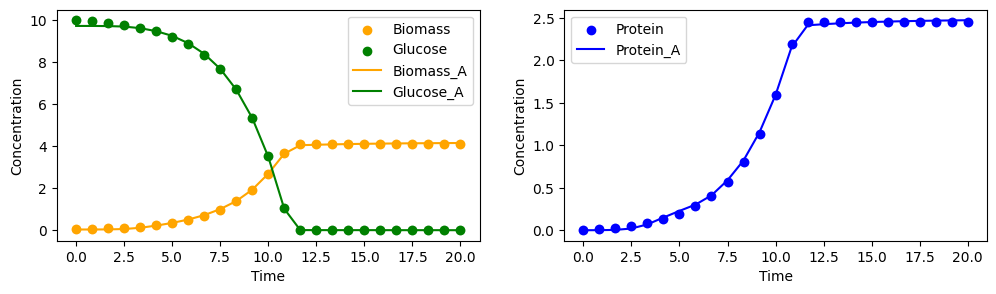

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].scatter(df['RTime'], df['Biomass'], color='orange', label="_Biomass", alpha=0.3)
ax[0].scatter(df['RTime'], df['Glucose'], color='green', label="_Glucose", alpha=0.3)
ax[0].scatter(train_df['RTime'], train_df['Biomass'], color='orange', label='Biomass', alpha=1.0)
ax[0].scatter(train_df['RTime'], train_df['Glucose'], color='green', label='Glucose', alpha=1.0)
ax[1].scatter(df['RTime'], df['Protein'], color='blue', label='_Protein', alpha=0.3)   
ax[1].scatter(train_df['RTime'], train_df['Protein'], color='blue', label='Protein', alpha=1.0)

ax[0].plot(u_pred['RTime'], u_pred['Biomass'], color='orange', label='Biomass_A')
ax[0].plot(u_pred['RTime'], u_pred['Glucose'], color='green', label='Glucose_A')
ax[1].plot(u_pred['RTime'], u_pred['Protein'], color='blue', label='Protein_A')

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Concentration')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Concentration')

plt.show()

In [105]:
def simulate(mu_max, alpha):

    def a(t):
        return alpha

    # System of ODE
    def ode_model(x,t):
        X,P,S,V = x
        mu = mu_max * S/(Ks + S)
        
        dX = -Fs(t)*X/V + mu * X
        dP = -Fs(t)*P/V + a(t) * mu * X
        dS = Fs(t)*(Sin-S)/V - mu * X / Yxs
        dV = Fs(t)
        return [dX,dP,dS,dV]
    
    t = np.linspace(T_START,T_END,NUM_SAMPLES)
    sol = odeint(ode_model,IC,t)
    return sol    


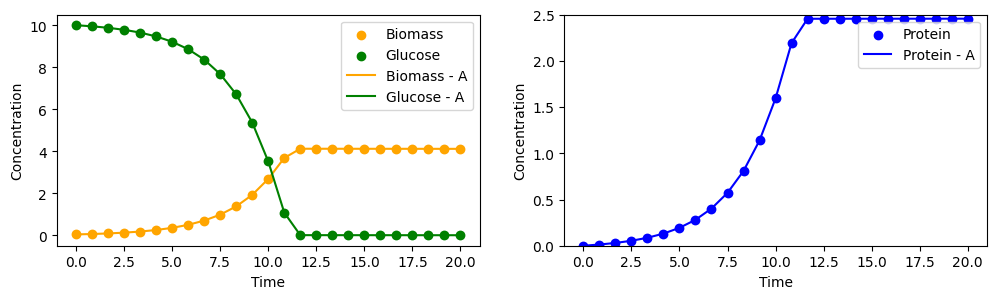

In [108]:
X, P, S, V = simulate(mu_max=net.mu_max.item(), alpha=net.alpha.item()).transpose()

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].scatter(df['RTime'], df['Biomass'], color='orange', label="_Biomass", alpha=0.2)
ax[0].scatter(df['RTime'], df['Glucose'], color='green', label="_Glucose", alpha=0.2)
ax[0].scatter(train_df['RTime'], train_df['Biomass'], color='orange', label='Biomass', alpha=1.0)
ax[0].scatter(train_df['RTime'], train_df['Glucose'], color='green', label='Glucose', alpha=1.0)
ax[1].scatter(df['RTime'], df['Protein'], color='blue', label='_Protein', alpha=0.2)   
ax[1].scatter(train_df['RTime'], train_df['Protein'], color='blue', label='Protein', alpha=1.0)

ax[0].plot(t, X, color='orange', linestyle='-', label='Biomass - A')
ax[0].plot(t, S, color='green', linestyle='-', label='Glucose - A')
ax[1].plot(t, P, color='blue', linestyle='-', label='Protein - A')

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Concentration')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Concentration')
ax[1].set_ylim(0, 2.5)
plt.show()